# RUMUSAN MASALAH
1. Apakah status tinggi air di pintu air atau curah hujan memprediksi banjir di wilayah tersebut?

2. Manakah yang lebih akurat untuk memprediksi banjir di suatu wilayah, status tinggi air di pintu air atau curah hujan?

# HIPOTESIS

1. Banjir dapat diprediksi berdasarkan status tinggi air di pintu air atau curah hujan di wilayah tersebut

2. Status tinggi air di pintu air lebih tepat digunakan untuk memprediksi banjir dibanding dengan data curah hujan  

# DATA YANG DIMILIKI
1. DATA KEJADIAN BANJIR TAHUN 2016-2020
2. DATA TINGGI AIR  TAHUN 2016-2020
3. CURAH HUJAN TAHUN 2016-2020







## Table of Contents

- [Introduction](#introduction)
- [Data Preprocessing](#data-preprocessing)
- [Model Training](#model-training)
- [Conclusion](#conclusion)

## Introduction
Your introduction content goes here.

## Data Preprocessing
Your data preprocessing content goes here.

## Model Training
Your model training content goes here.

## Conclusion
Your conclusion content goes here.


# LIBRARY

In [137]:
#Library Dataframe
import pandas as pd, numpy as np
#Library Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
#Library math

#
!pip install folium matplotlib mapclassify
import geopandas
!pip install geodatasets
import geodatasets
import folium
from folium.plugins import TimeSliderChoropleth

from geopy.geocoders import Nominatim

import re
import calendar

#sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

#xgboost
import xgboost as xgb

#lightGBM
import lightgbm as lgb

#Catboost
!pip install catboost
from catboost import CatBoostClassifier

#tensor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import time
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.7 MB/s eta 0:00:00


# Data assessment & preprocessing

## Data Kejadian Banjir
Fitur yang tersedia sebagai berikut :
1. kota_administrasi
2. kecamatan
3. kelurahan
4. rw
5. jumlah_terdampak_rw
6. jumlah_terdampak_rt
7. jumlah_terdampak_kk
8. jumlah_terdampak_jiwa
9. ketinggian_air
10. tanggal_kejadian
11. lama_genangan
12. jumlah_meninggal
13. jumlah_hilang
14. jumlah_luka_berat
15. jumlah_luka_ringan
16. jumlah_pengungsi_tertinggi
17. jumlah_tempat_pengungsian
18. nilai_kerugian

Data diambil dari web https://data.jakarta.go.id/dataset?q=banjir dari tahun 2016-2020

### Baca File dan Gabung data (Merge)

In [2]:
#list tahun dari 2016 sampai 2020
tahun_list = [2016,2017,2018,2019,2020]
#list bulan
bulan_list = ['januari','febuari','maret',
          'april','mei','juni','juli',
          'agustus','september','november'
          ,'oktober','desember']
hari_list = ['01','02','03','04','05','06','07','08','09',
             '10','11','12','13','14','15','16','17','18',
             '19','20','21','22','23','24','25','26','27',
             '28','29','30','31']

In [3]:
#buat dataframe kosong
data_kejadian_banjir = pd.DataFrame()
#melakukan looping untuk tahun
for i in tahun_list:
  #melakukan looping untuk bulan
  for j in range(len(bulan_list)):
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-kejadian-bencana-banjir-di-provinsi-dki-jakarta-tahun-{i}-bulan-{str(bulan_list[j])}.csv'
      data = pd.read_csv(path)
    except: continue

    #menambahkan kolom tahun
    data = data.assign(tahun=i)
    #menambahkan kolom bulan
    data = data.assign(bulan=j+1)
    #menggabungkan data kedalam dataset data_kejadian_banjir
    data_kejadian_banjir = pd.concat([data_kejadian_banjir,data])

In [4]:
data_kejadian_banjir.sample(2)

,kota_administrasi,kecamatan,kelurahan,rw,jumlah_terdampak_rw,jumlah_terdampak_rt,jumlah_terdampak_kk,jumlah_terdampak_jiwa,ketinggian_air,tanggal_kejadian,lama_genangan,jumlah_meninggal,jumlah_hilang,jumlah_luka_berat,jumlah_luka_ringan,jumlah_pengungsi_tertinggi,jumlah_tempat_pengungsian,nilai_kerugian,tahun,bulan
311,Jakarta Timur,CIPAYUNG,BAMBU APUS,RW 02,1.0,1.0,0.0,0.0,60 cm,"10,11 Oktober",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,11
6,Jakarta Barat,Cengkareng,Kedaung Kaliangke,"001, 005, 008",3.0,8.0,0.0,0.0,5 - 15,01\n,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,3


In [5]:
data_kejadian_banjir.shape

(1623, 20)

In [6]:
#melihat info dataset
data_kejadian_banjir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 0 to 46
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   kota_administrasi           1571 non-null   object 
 1   kecamatan                   1571 non-null   object 
 2   kelurahan                   1571 non-null   object 
 3   rw                          1571 non-null   object 
 4   jumlah_terdampak_rw         1571 non-null   float64
 5   jumlah_terdampak_rt         1571 non-null   float64
 6   jumlah_terdampak_kk         1571 non-null   float64
 7   jumlah_terdampak_jiwa       1571 non-null   float64
 8   ketinggian_air              1571 non-null   object 
 9   tanggal_kejadian            1571 non-null   object 
 10  lama_genangan               1571 non-null   float64
 11  jumlah_meninggal            1571 non-null   float64
 12  jumlah_hilang               1571 non-null   float64
 13  jumlah_luka_berat           1571 no

### Cleaning Data

In [7]:
#Melihat nilai yang hilang pada dataset
data_kejadian_banjir.isna().sum()

kota_administrasi             52
kecamatan                     52
kelurahan                     52
rw                            52
jumlah_terdampak_rw           52
jumlah_terdampak_rt           52
jumlah_terdampak_kk           52
jumlah_terdampak_jiwa         52
ketinggian_air                52
tanggal_kejadian              52
lama_genangan                 52
jumlah_meninggal              52
jumlah_hilang                 52
jumlah_luka_berat             52
jumlah_luka_ringan            52
jumlah_pengungsi_tertinggi    52
jumlah_tempat_pengungsian     52
nilai_kerugian                52
tahun                          0
bulan                          0
dtype: int64

In [8]:
fitur = data_kejadian_banjir.columns
#merubah semua nilai pada data tipe string menjadi lowercase
for row in fitur:
  try:
    data_kejadian_banjir[row] = data_kejadian_banjir[row].str.lower()
  except: continue

In [9]:
#Menghilangkan nilai yang hilang pada dataset
data_kejadian_banjir = data_kejadian_banjir.dropna(subset=['kecamatan'])

In [10]:
#menambahkan kolom jumlah_banjir dalam sebulan
data_kejadian_banjir['jumlah_banjir'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: len(x.split(',')))

<ipython-input-10-ac5c783e32ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kejadian_banjir['jumlah_banjir'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: len(x.split(',')))


In [11]:
#menghilangkan string yang masih ada 'kec.'
data_kejadian_banjir['tanggal_kejadian'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: x.split('(')[0])

<ipython-input-11-c3e69dfe748d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kejadian_banjir['tanggal_kejadian'] = data_kejadian_banjir['tanggal_kejadian'].apply(lambda x: x.split('(')[0])


In [12]:
fitur_delete = ['jumlah_terdampak_rt','jumlah_terdampak_kk','jumlah_meninggal',
                'jumlah_hilang', 'jumlah_luka_berat',
                'jumlah_luka_ringan', 'jumlah_pengungsi_tertinggi',
                'jumlah_tempat_pengungsian', 'nilai_kerugian',
                'jumlah_terdampak_jiwa']
#menghapus kolom yang tidak di perlukan
data_kejadian_banjir = data_kejadian_banjir.drop(fitur_delete,axis=1)


In [13]:
data_kejadian_banjir.columns

Index(['kota_administrasi', 'kecamatan', 'kelurahan', 'rw',
       'jumlah_terdampak_rw', 'ketinggian_air', 'tanggal_kejadian',
       'lama_genangan', 'tahun', 'bulan', 'jumlah_banjir'],
      dtype='object')

In [14]:
data_kejadian_banjir.shape

(1571, 11)

In [15]:
data_kejadian_banjir['kota_administrasi'].unique()

array(['jakarta selatan', 'jakarta timur', 'jakarta barat',
       'jakarta utara', 'jakarta pusat', 'kepulauan seribu',
       'jakarta urata'], dtype=object)

In [16]:
data_kejadian_banjir.loc[data_kejadian_banjir['kota_administrasi'] == 'jakarta Urata', 'kota_administrasi'] ='jakarta Utara'

In [17]:
data_kejadian_banjir['kota_administrasi'].unique()

array(['jakarta selatan', 'jakarta timur', 'jakarta barat',
       'jakarta utara', 'jakarta pusat', 'kepulauan seribu',
       'jakarta urata'], dtype=object)

In [18]:
data_kejadian_banjir['kecamatan'].unique()

array(['kebayoran baru', 'kebayoran lama', 'pancoran', 'pasar minggu',
       'pesanggrahan', 'tebet', 'jatinegara', 'kramat jati', 'cengkareng',
       'grogol petamburan', 'kalideres', 'kebon jeruk', 'kembangan',
       'cilandak', 'jagakarsa', 'mampang prapatan', 'cakung', 'cipayung',
       'ciracas', 'makasar', 'pasar rebo', 'pulogadung', 'cilincing',
       'kelapa gading', 'koja', 'penjaringan', 'taman sari', 'pademangan',
       'gambir', 'kedoya selatan', 'duren sawit', 'jagakarta',
       'tanjung priok', 'kali deres', 'kemayoran', 'setia budi',
       'kec. cengkareng', 'kec. kembangan ', 'kec. palmerah',
       'kec. kebon jeruk', 'kec. cilandak', 'kec. mampang prapatan',
       'kec. jagakarsa', 'kec. pasar minggu', 'kec. kebayoran lama',
       'kec. cakung', 'kec. pasar rebo', 'kec. jatinegara',
       'kec. ciracas', 'kec. makasar', 'kec. kramat jati', 'makassar',
       'kec.kembangan', 'kec.kebayoran lama', 'kec.cilandak',
       'kec.kebayoran baru', 'cempaka putih',

In [19]:
#menghilangkan string yang masih ada 'kec. '
data_kejadian_banjir['kecamatan'] = data_kejadian_banjir['kecamatan'].apply(lambda x: x.split('kec. ')[-1])
#menghilangkan string yang masih ada 'kec.'
data_kejadian_banjir['kecamatan'] = data_kejadian_banjir['kecamatan'].apply(lambda x: x.split('kec.')[-1])
#menghilangkan spasi tambahan pada string
data_kejadian_banjir['kecamatan'] = data_kejadian_banjir['kecamatan'].str.strip()


In [20]:
data_kejadian_banjir['kecamatan'].unique()

array(['kebayoran baru', 'kebayoran lama', 'pancoran', 'pasar minggu',
       'pesanggrahan', 'tebet', 'jatinegara', 'kramat jati', 'cengkareng',
       'grogol petamburan', 'kalideres', 'kebon jeruk', 'kembangan',
       'cilandak', 'jagakarsa', 'mampang prapatan', 'cakung', 'cipayung',
       'ciracas', 'makasar', 'pasar rebo', 'pulogadung', 'cilincing',
       'kelapa gading', 'koja', 'penjaringan', 'taman sari', 'pademangan',
       'gambir', 'kedoya selatan', 'duren sawit', 'jagakarta',
       'tanjung priok', 'kali deres', 'kemayoran', 'setia budi',
       'palmerah', 'makassar', 'cempaka putih', 'setiabudi',
       'kepulauan seribu selatan', 'sawah besar', 'senen', 'tambora',
       'matraman', 'johar baru', 'tanah abang', 'kepulauan seribu utara',
       'mampang', 'pulo gadung'], dtype=object)

In [21]:
data_kejadian_banjir['kelurahan'].unique()

array(['cipete utara', 'petogogan', 'rawa barat', 'cipulir',
       'pondok pinang', 'rawajati', 'pejaten timur', 'ulujami',
       'bukit duri', 'kebon baru', 'bidara cina', 'kampung melayu',
       'cawang', 'cengkareng barat', 'cengkareng timur', 'duri kosambi',
       'kapuk', 'kedaung kali angke', 'rawa buaya', 'wijaya kesuma',
       'kalideres', 'kamal', 'pegadungan', 'tegal alur', 'kedoya utara',
       'kelapa dua', 'joglo', 'kembangan utara', 'meruya utara',
       'srengseng', 'cilandak barat', 'lebak bulus', 'pondok labu',
       'ciganjur', 'jagakarsa', 'lenteng agung', 'srengseng sawah',
       'grogol utara', 'bangka', 'pela mampang', 'kalibata', 'pengadegan',
       'kebagusan', 'cakung barat', 'cakung timur', 'jatinegara',
       'rawa terate', 'cilangkap', 'pondok ranggon', 'cibubur', 'ciracas',
       'kelapa dua wetan', 'rambutan', 'cipinang muara', 'bale kambang',
       'batu ampar', 'cililitan', 'dukuh', 'cipinang melayu',
       'halim perdana kusuma', 'kebon pa

In [22]:
#menghilangkan string yang masih ada 'kel. '
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].apply(lambda x: x.split('kel. ')[-1])
#menghilangkan string yang masih ada 'kel.'
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].apply(lambda x: x.split('kel.')[-1])
#menghilangkan string yang masih ada 'kel '
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].apply(lambda x: x.split('kel ')[-1])
#menghilangkan spasi tambahan pada string
data_kejadian_banjir['kelurahan'] = data_kejadian_banjir['kelurahan'].str.strip()
#menghilangkan string 0
data_kejadian_banjir = data_kejadian_banjir[data_kejadian_banjir['kelurahan'] != '0']


In [23]:
#mengganti nilai yang salah
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'pengadengan', 'kelurahan'] ='pengadegan'
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'rambuta', 'kelurahan'] ='rambutan'
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'pulo', 'kelurahan'] ='pulo gadung'
data_kejadian_banjir.loc[data_kejadian_banjir['kelurahan'] == 'makasar', 'kelurahan'] ='makassar'

In [24]:
sorted(data_kejadian_banjir['kelurahan'].unique())

['ancol',
 'bale kambang',
 'balekambang',
 'bambu apus',
 'bangka',
 'baru',
 'batu ampar',
 'bendungan hilir',
 'bidara cina',
 'bintaro',
 'bukit duri',
 'cakung barat',
 'cakung timur',
 'cawang',
 'ceger',
 'cempaka putih barat',
 'cempaka putih timur',
 'cengkareng barat',
 'cengkareng timur',
 'cibubur',
 'ciganjur',
 'cijantung',
 'cikoko',
 'cilandak barat',
 'cilandak timur',
 'cilangkap',
 'cililitan',
 'cilincing',
 'cipayung',
 'cipedak',
 'cipete selatan',
 'cipete utara',
 'cipinang',
 'cipinang besar selatan',
 'cipinang cempedak',
 'cipinang melayu',
 'cipinang muara',
 'cipulir',
 'ciracas',
 'dukuh',
 'duren sawit',
 'duren tiga',
 'duri kepa',
 'duri kosambi',
 'gambir',
 'gandaria selatan',
 'gandaria utara',
 'gedong',
 'grogol selatan',
 'grogol utara',
 'guntur',
 'gunung',
 'gunung sahari selatan',
 'gunung sahari utara',
 'halim perdana kusuma',
 'jagakarsa',
 'jati',
 'jati padang',
 'jati pulo',
 'jatinegara',
 'jatipadang',
 'jelambar',
 'jelambar baru',
 '

In [25]:
data_kejadian_banjir.sample()

,kota_administrasi,kecamatan,kelurahan,rw,jumlah_terdampak_rw,ketinggian_air,tanggal_kejadian,lama_genangan,tahun,bulan,jumlah_banjir
22,jakarta barat,kebon jeruk,kedoya selatan,rw 10,1.0,10 cm,11 oktober,0.0,2020,11,1


In [26]:
data_kejadian_banjir.shape

(1570, 11)

## Data Tinggi Air
Fitur yang tersedia sebagai berikut :
1. tahun
2. bulan
3. nama_pintu_air
4. lokasi
5. latitude
6. longitude
7. rata rata tinggi_air
8. status_siaga

### baca File dan Gabung data (Merge)

In [27]:
#list tahun dari 2016 sampai 2020
tahun_list = [2016,2017,2018,2019,2020]
#list bulan
bulan_list = ['januari','febuari','maret',
          'april','mei','juni','juli',
          'agustus','september','november'
          ,'oktober','desember']

In [28]:
#buat dataframe kosong
data_tinggi_air = pd.DataFrame()
#melakukan looping untuk tahun
for i in tahun_list:
  #melakukan looping untuk bulan
  for j in range(len(bulan_list)):
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-tinggi-muka-air-{str(bulan_list[j])}-{i}.csv'
      data = pd.read_csv(path)
    except: continue
    data = data.dropna(subset=['tanggal'])
    try:
      data = data[~data['tanggal'].str.contains('0000')]
    except:continue
    data['tanggal'] = pd.to_datetime(data['tanggal'])
    #menambahkan kolom tahun
    data['tahun'] = data['tanggal'].dt.year
    #menambahkan kolom bulan
    data['bulan'] = data['tanggal'].dt.month
    data['hari'] = data['tanggal'].dt.day
    #menggabungkan data kedalam dataset data_kejadian_banjir
    data_tinggi_air = pd.concat([data_tinggi_air,data]).reset_index(drop=True)

data_tinggi_air['tanggal'] = pd.to_datetime(data_tinggi_air['tahun'].astype(str) + '-' + data_tinggi_air['bulan'].astype(str) + '-' + data_tinggi_air['hari'].astype(str))
data_tinggi_air['tinggi_air'] = data_tinggi_air['tinggi_air']/10

<ipython-input-28-242c2e3aed33>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tanggal'] = pd.to_datetime(data['tanggal'])
<ipython-input-28-242c2e3aed33>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tahun'] = data['tanggal'].dt.year
<ipython-input-28-242c2e3aed33>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [29]:
data_tinggi_air.sample()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,waktu
1077107,PS. Katulampa (Hulu),Ciliwung,-6.633167,106.836806,2018-11-22,10.0,Status : Normal,2018,11,22,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data_tinggi_air.shape

(1879498, 16)

### Cleaning Data

In [31]:
print(data_tinggi_air[' '].unique())
print(data_tinggi_air['Unnamed: 7'].unique())
print(data_tinggi_air['Unnamed: 8'].unique())
print(data_tinggi_air['Unnamed: 9'].unique())

[nan ' ']
[nan]
[nan ' ']
[nan '  ']


In [32]:
#Menghapus fitur yang tidak perlu
data_tinggi_air.drop([' ','Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],axis=1,inplace=True)

In [33]:
data_tinggi_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879498 entries, 0 to 1879497
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   nama_pintu_air  object        
 1   lokasi          object        
 2   latitude        float64       
 3   longitude       float64       
 4   tanggal         datetime64[ns]
 5   tinggi_air      float64       
 6   status_siaga    object        
 7   tahun           int64         
 8   bulan           int64         
 9   hari            int64         
 10  Unnamed: 10     object        
 11  waktu           object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 172.1+ MB


In [34]:
data_tinggi_air.duplicated().sum()

1443697

In [35]:
data_tinggi_air.sample(5)

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu
1041532,P.A. Jembatan Merah,Ciliwung,-6.149068,106.834214,2018-10-24,139.0,Status : Siaga 3,2018,10,24,NaN,NaN
1365238,PS. Cipinang Hulu,Cipinang Hulu,-6.374264,106.883862,2019-05-19,80.0,Status : Normal,2019,5,19,NaN,NaN
1032310,PS. Cipinang Hulu,Cipinang Hulu,-6.374264,106.883862,2018-10-21,76.0,Status : Normal,2018,10,21,NaN,NaN
1216970,P.A. Jembatan Merah,Ciliwung,-6.149068,106.834214,2019-01-15,147.0,Status : Siaga 3,2019,1,15,NaN,5:40:00AM
293414,PA. Tanjungan (Laut),Tanjungan,-6.106601,106.725045,2017-08-06,176.0,Normal,2017,8,6,NaN,NaN


In [36]:
#Menghapus nilai duplikat pada dataset
data_tinggi_air = data_tinggi_air.drop_duplicates()


In [37]:
#melihat jumlah nilai yang hilang
data_tinggi_air.isna().sum()

nama_pintu_air         0
lokasi                 0
latitude            4543
longitude           4543
tanggal                0
tinggi_air           571
status_siaga           0
tahun                  0
bulan                  0
hari                   0
Unnamed: 10       435801
waktu             356113
dtype: int64

In [38]:
#drop data yang hilang pada fitur tinggi air
data_tinggi_air = data_tinggi_air.dropna(subset=['tinggi_air'])

In [39]:
data_tinggi_air['nama_pintu_air'].unique()

array(['PS. Depok', 'P.A. Karet', 'P.A Cideng - Siantar',
       'PS. Krukut Hulu', 'PS. Manggarai', 'PS. Kp. Melayu',
       'PS. Marunda', 'PS. Katulampa (Hulu)', 'PS. Cibogo',
       'P.A. Marina Ancol ', 'PA. Pasar Ikan (Laut)', 'PS. Cipinang Hulu',
       'P.A. Yos Sudarso 1', 'PA. Pulo Gadung', 'PS. Sunter Hulu',
       'PA. Tanjungan (Laut)', 'PA. Angke Hulu', 'PS. Pesanggrahan',
       'P.A. Pluit', 'PS. Marunda (LautP', 'PS. Marunda (Laut)',
       ' P.A Kali Duri (Kalijodo)', 'P.A. Jembatan Merah', 'P.A. Hek',
       'P.A. Istiqal  ', 'P.A. Ancol Flusing', 'PA. Manggarai',
       'Pompa Cideng', 'Pompa Pasar Ikan', 'Pompa Yos Sudarso 1',
       'Pompa Kali Duri (Kalijodo)', 'P.A. Istiqlal  ', 'PS. Angke Hulu',
       'Pompa Tanjungan', 'P.A Kali Duri (Kalijodo)', 'PA. Pasar Ikan',
       'PA. Tanjungan', 'PHB Tanjungan', 'PA. Cibalok - Gadog',
       'P.A. Flusing Ancol', 'Bendung. Cibalok - Gadog',
       'Bendung. Katulampa (Hulu)', 'Pompa. Pluit'], dtype=object)

In [40]:
drop_pintu_air = ['ps.pesang','PS. Depok','PS. Katulampa (Hulu)','PS. Katulampa (Hulu)',
                  'Bendung. Cibalok - Gadog','PS. Pesanggrahan','PS. Cipinang Hulu']

In [41]:
data_tinggi_air = data_tinggi_air[~data_tinggi_air['nama_pintu_air'].isin(drop_pintu_air)]

In [42]:
data_tinggi_air[(data_tinggi_air['tanggal'] > '2021-01-01') |((data_tinggi_air['tanggal'] < '2015-01-01')) ]

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu
201202,PS. Marunda,Banjir Kanal Timur,-6.108719,106.969067,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204603,PS. Cibogo,Ciliwung,-6.657083,106.878083,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204606,PS. Kp. Melayu,Ciliwung,-6.225753,106.864228,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204607,PS. Manggarai,Ciliwung,-6.207825,106.848458,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204608,PS. Krukut Hulu,Krukut,-6.343900,106.798874,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204609,P.A Cideng - Siantar,Krukut,-6.173271,106.806351,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204610,P.A. Karet,Banjir Kanal Barat,-6.197901,106.810075,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204611,P.A. Marina Ancol,Laut,-6.125585,106.830154,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204612,PA. Pasar Ikan (Laut),Pasar Ikan,-6.126132,106.809783,1970-01-01,0.0,Normal,1970,1,1,NaN,NaN
204613,P.A. Pluit,Waduk Pluit,-6.109076,106.796649,1970-01-01,0.0,Siaga 1,1970,1,1,NaN,NaN


In [43]:
drop_tahun = [1970,2021,2023,2032,2029]
data_tinggi_air = data_tinggi_air[~data_tinggi_air['tahun'].isin(drop_tahun)]

In [44]:
#Menggabungkan penamaan Status_siaga
data_tinggi_air['status_siaga'] = data_tinggi_air['status_siaga'].apply(lambda x: x.split(': ')[-1])

In [45]:
data_tinggi_air['status_siaga'].value_counts()

Normal     291276
Siaga 3     59112
Siaga 2     31407
Siaga 1      4207
Name: status_siaga, dtype: int64

In [46]:
fitur = data_tinggi_air.columns
#merubah semua nilai pada data tipe string menjadi lowercase
for row in fitur:
  try:
    data_tinggi_air[row] = data_tinggi_air[row].str.lower()
  except: continue

In [47]:
#data_tinggi_air = data_tinggi_air.groupby(['tanggal','tahun','bulan','hari','nama_pintu_air',
                                     # 'lokasi', 'latitude', 'longitude'],
                                      #    sort=False).agg({'tinggi_air': 'mean',
                                         #                  'status_siaga': lambda x: x.mode()[0]}).reset_index()

In [48]:
data_tinggi_air.head()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu
1,p.a. karet,banjir kanal barat,-6.197901,106.810075,2016-11-25,371.0,normal,2016,11,25,NaN,NaN
2,p.a cideng - siantar,krukut,-6.173271,106.806351,2016-11-25,44.0,normal,2016,11,25,NaN,NaN
3,ps. krukut hulu,krukut,-6.343900,106.798874,2016-11-25,48.0,normal,2016,11,25,NaN,NaN
4,ps. manggarai,ciliwung,-6.207825,106.848458,2016-11-25,619.0,normal,2016,11,25,NaN,NaN
5,ps. kp. melayu,ciliwung,-6.225753,106.864228,2016-11-25,611.0,normal,2016,11,25,NaN,NaN


## Data Curah Hujan
Fitur yang tersedia sebagai berikut :
1. year
2. month
3. day
4. PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/day)
5. TS              MERRA-2 Earth Skin Temperature (C)

### baca File dan Gabung data (Merge)

In [49]:
kota_list = ['jakarta barat','jakarta timur','jakarta selatan','jakarta pusat','jakarta utara']
#dataframe kosong
data_curah_hujan = pd.DataFrame()
#looping terhadap kota_list
for i in kota_list:
  #path adalah tempat data di simpan,
  #semua file di simpan di satu folder
  #gunakan nama yang sama kecuali kota nya
  path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/curah hujan/{i}_curah_hujan.csv'
  data = pd.read_csv(path,header=10)
  #ganti nama kolom
  data.columns = ['tahun','bulan','hari','suhu','curah_hujan']
  #menambahkan kolom nama kota
  data = data.assign(kota=i)
  #gabungkan data dengan data_curah_hujan
  data_curah_hujan = pd.concat([data_curah_hujan,data])

In [50]:
data_curah_hujan.sample(2)

,tahun,bulan,hari,suhu,curah_hujan,kota
760,2018,1,30,27.31,8.58,jakarta barat
1035,2018,11,1,26.81,13.50,jakarta selatan


In [51]:
data_curah_hujan.shape

(9135, 6)

In [52]:
data_curah_hujan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9135 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tahun        9135 non-null   int64  
 1   bulan        9135 non-null   int64  
 2   hari         9135 non-null   int64  
 3   suhu         9135 non-null   float64
 4   curah_hujan  9135 non-null   float64
 5   kota         9135 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 499.6+ KB


### Cleaning Data

In [53]:
#mengurutkan dari 2016 ke 2020
data_curah_hujan = data_curah_hujan.sort_values(by=['tahun','bulan','hari']).reset_index(drop=True)

In [54]:
data_curah_hujan.sample(2)

,tahun,bulan,hari,suhu,curah_hujan,kota
2553,2017,5,25,27.81,0.09,jakarta pusat
9011,2020,12,7,27.79,5.48,jakarta timur


# Exploratory Data Analysis (EDA)

1. data_kejadian_banjir

2. data_tinggi_air

3. data_curah_hujan

### Mencari Anomali

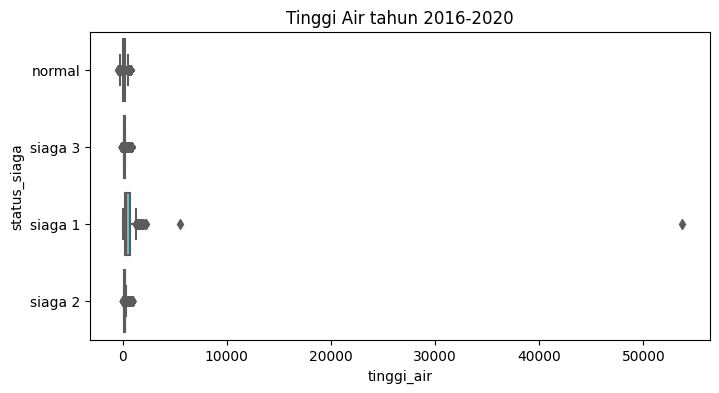

In [55]:
plt.figure(figsize=(8,4),frameon=True)
plt.title('Tinggi Air tahun 2016-2020')
sns.boxplot(data = data_tinggi_air,
            x='tinggi_air',
             y='status_siaga',
            palette='hls',)
plt.show()

In [56]:
data_tinggi_air.shape

(386002, 12)

In [57]:
def outlier_tinggi_air(data,status):
  data_status = data[data['status_siaga'] == status]
  boxplot = plt.boxplot(data_status['tinggi_air'].values)
  plt.close()
  outliers = list(boxplot['fliers'][0].get_data()[1])
  data = data[~data["tinggi_air"].isin(outliers)]
  return data

In [58]:
status = ['normal','siaga 1','siaga 2','siaga 3']
for i in status:
  data_tinggi_air = outlier_tinggi_air(data_tinggi_air,i)

In [59]:
data_tinggi_air.shape

(297277, 12)

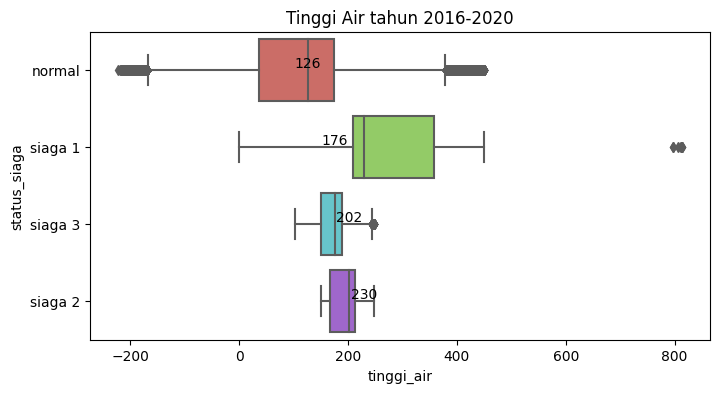

In [60]:
data = data_tinggi_air.groupby('status_siaga')['tinggi_air'].median().sort_values().values.astype(int)
plt.figure(figsize=(8,4),frameon=True)
plt.title('Tinggi Air tahun 2016-2020')
sns.boxplot(data = data_tinggi_air.sort_values(by='tinggi_air'),
            x='tinggi_air',
             y='status_siaga',
            palette='hls',)
for i in range(len(data)):
      plt.text(data[i],i,str(data[i]), ha='center', va='bottom')
plt.show()

### Grafik Sebaran Banjir Jakarta

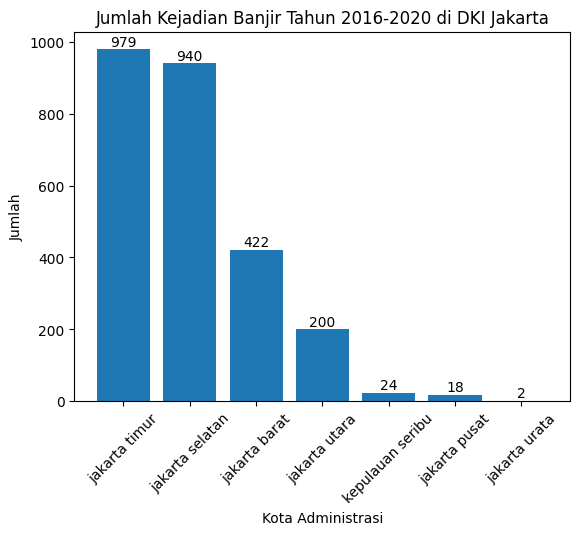

In [61]:
#Mengelompokan jumlah kejadian berdasarkan kota administrasi
data = data_kejadian_banjir.groupby('kota_administrasi')['jumlah_banjir'].sum().sort_values(ascending=False)

#Grafik Bar
plt.bar(data.index, data.values)

# Memberikan judul dan label pada sumbu
for i in range(len(data)):
    plt.text(i, data[i], str(data[i]), ha='center', va='bottom')
plt.title('Jumlah Kejadian Banjir Tahun 2016-2020 di DKI Jakarta')
plt.xlabel('Kota Administrasi')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

# Menampilkan grafik
plt.show()

### Grafik sebaran banjir per kota administrasi

In [62]:
def grafik_kecamatan(kota,shift):
  data = data_kejadian_banjir[data_kejadian_banjir['kota_administrasi'] == kota].groupby(
      'kecamatan')['jumlah_banjir'].sum().sort_values(ascending=True)
  #Grafik Bar
  plt.barh(data.index, data.values)

  # Memberikan judul dan label pada sumbu
  for i in range(len(data)):
      plt.text(data[i]+shift,i-0.3,str(data[i]), ha='center', va='bottom')
  plt.title(f'Jumlah Kejadian Banjir Tahun 2016-2020 di {kota}')
  plt.xlabel('Jumlah')
  plt.ylabel('Kecamatan')

  # Menampilkan grafik
  plt.show()

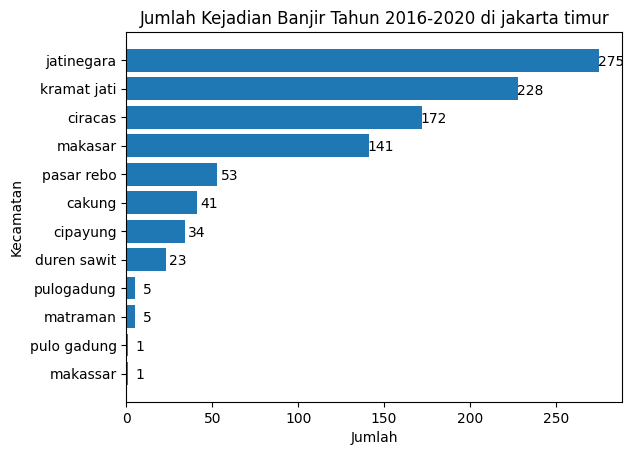

In [63]:
grafik_kecamatan('jakarta timur',7)

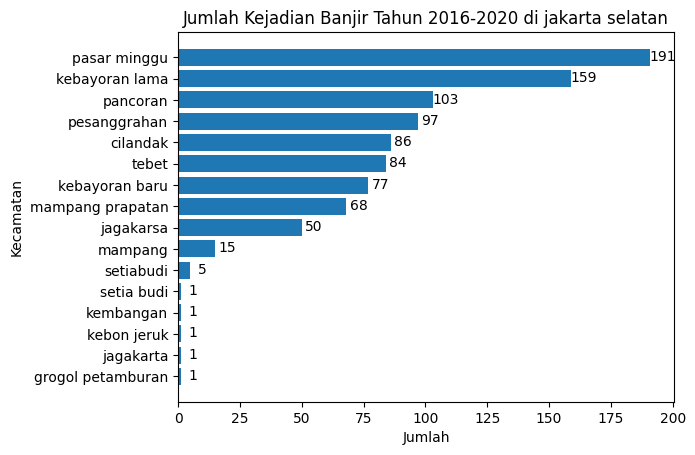

In [64]:
grafik_kecamatan('jakarta selatan',5)

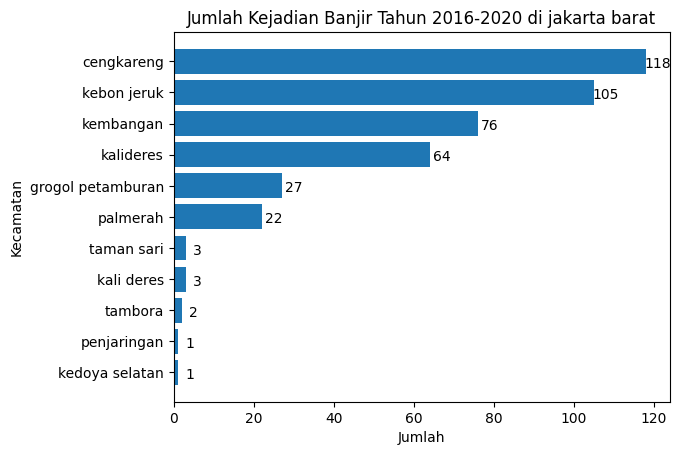

In [65]:
grafik_kecamatan('jakarta barat',3)

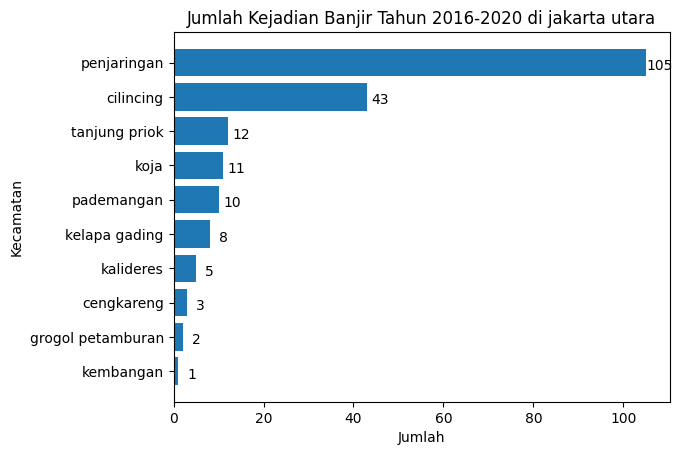

In [66]:
grafik_kecamatan('jakarta utara',3)

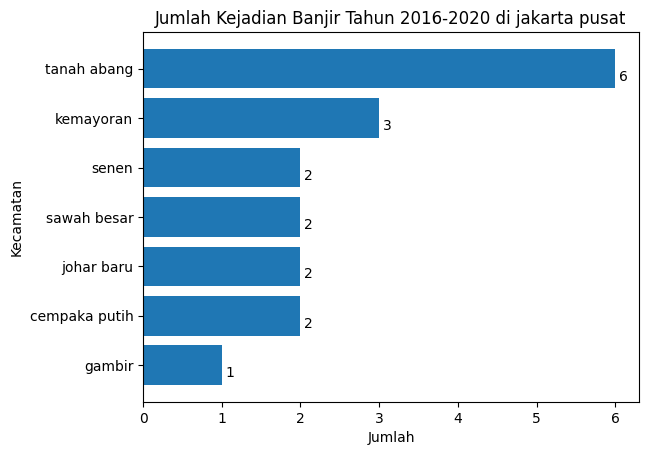

In [67]:
grafik_kecamatan('jakarta pusat',0.1)

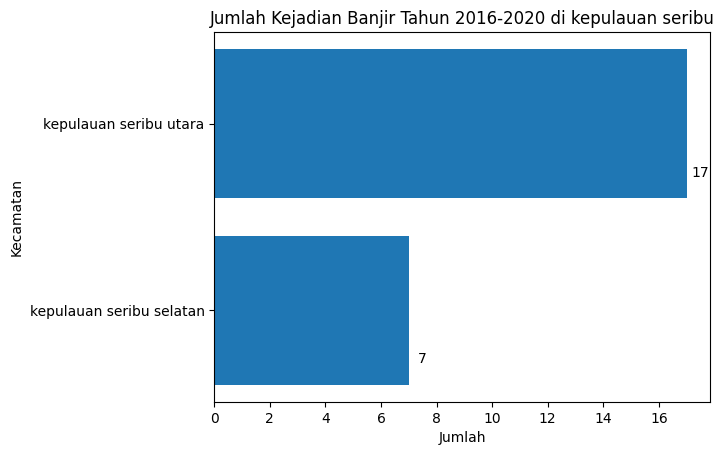

In [68]:
grafik_kecamatan('kepulauan seribu',0.5)

In [69]:
data_kejadian_banjir['bulan'].value_counts()

11    403
1     207
4     170
3     169
10    157
12    115
5      86
2      70
9      60
6      53
8      44
7      36
Name: bulan, dtype: int64

# Geografis Jakarta


In [70]:
kota = ['jakarta pusat','jakarta utara','jakarta timur',
        'jakarta selatan','jakarta barat','kepulauan seribu']
columns_drop = ['KDPPUM', 'KDPBPS', 'FCODE', 'LUASWH', 'UUPP',
       'SRS_ID','KDEBPS', 'KDEPUM', 'KDCBPS', 'KDCPUM',
       'KDBBPS', 'KDBPUM','WADMKD', 'WIADKD', 'WADMKC', 'WIADKC', 'WADMKK',
       'WIADKK', 'WADMPR', 'WIADPR', 'TIPADM','METADATA','REMARK','LCODE']
#buat dataframe kosong
geo_jakarta = pd.DataFrame()
#melakukan looping untuk tahun
for i in kota:
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data_shape/{i}/ADMINISTRASIKECAMATAN_AR_25K.shp'
      data = gpd.read_file(path)
    except: continue
    data = data.drop(columns_drop,axis=1)
    #menambahkan kolom tahun
    data = data.assign(kota=i)
    data = data.rename(columns={'NAMOBJ':'kecamatan'})
    #menggabungkan data kedalam dataset data_kejadian_banjir
    geo_jakarta = pd.concat([geo_jakarta,data])
geo_jakarta['kecamatan'] = geo_jakarta['kecamatan'].str.lower()

In [71]:
geo_jakarta.sample()

,kecamatan,SHAPE_Leng,SHAPE_Area,geometry,kota
6,pasar minggu,0.294642,0.001819,"POLYGON Z ((106.85558 -6.26753 0.00000, 106.85...",jakarta selatan


In [72]:
geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set1",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

In [73]:
# Mengonversi DataFrame menjadi GeoDataFrame
gdf_data_tinggi_air = gpd.GeoDataFrame(data_tinggi_air, geometry=gpd.points_from_xy(data_tinggi_air['longitude'], data_tinggi_air['latitude']))

In [74]:
gdf_data_tinggi_air.sample()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu,geometry
1611294,p.a. istiqlal,ciliwung,-6.168254,106.83135,2020-03-04,185.0,normal,2020,3,4,NaN,NaN,POINT (106.83135 -6.16825)


#### Lokasi Pintu Air

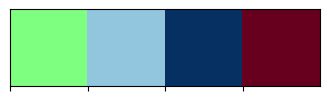

In [75]:
color_scale = np.array(['#7FFF7F','#92c5de','#053061','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [76]:
def color_coding(data):
  if data['status_siaga'] == 'normal':
    return color_scale[0]
  if data['status_siaga'] == 'siaga 1':
    return color_scale[1]
  if data['status_siaga'] == 'siaga 2':
    return color_scale[2]
  if data['status_siaga'] == 'siaga 3':
    return color_scale[3]

In [77]:
geo_data_tinggi_air = data_tinggi_air.copy()
geo_data_tinggi_air['color'] = geo_data_tinggi_air.apply(color_coding,axis=1)
geo_data_tinggi_air['tanggal'] = pd.to_datetime(geo_data_tinggi_air['tahun'].astype(str) + '-' + geo_data_tinggi_air['bulan'].astype(str) + '-1')

In [78]:
geo_data_tinggi_air.sample()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,tahun,bulan,hari,Unnamed: 10,waktu,color
1562125,p.a. pluit,waduk pluit,-6.109642,106.796954,2019-12-01,-180.0,normal,2019,12,17,NaN,NaN,#7FFF7F


In [79]:
features_data_air = []
for _, row in geo_data_tinggi_air.iterrows():
  feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point',
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['tanggal'].date().__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 5
                },
                'popup':True,
                'tooltip':row['nama_pintu_air']
            }
        }
  features_data_air.append(feature)



In [80]:
from folium.plugins import TimestampedGeoJson
m = geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set2",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)
TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features_data_air}
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM'
        , time_slider_drag_update=True
    ).add_to(m)
folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m

#### Lokasi Banjir

In [81]:
address = data_kejadian_banjir[['kota_administrasi','kecamatan','kelurahan']]

In [82]:
address.sample()

In [83]:
address['alamat'] = address['kelurahan'] + ',' + address['kota_administrasi']

In [84]:
alamat = address['alamat'].unique()

In [ ]:
geolocator = Nominatim(user_agent="my_app")
koordinat_kelurahan =[]
for kelurahan in alamat:
    location = geolocator.geocode(kelurahan)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        koordinat_kelurahan.append((kelurahan, latitude, longitude))
    else:
        koordinat_kelurahan.append((kelurahan, None, None))

In [ ]:
loc_kelurahan = pd.DataFrame(koordinat_kelurahan).rename(columns={0:'alamat',1:'latitude',2:'longitude'})

In [ ]:
loc_kelurahan['longitude'].isna().sum()

In [ ]:
loc_kelurahan[loc_kelurahan['longitude'].isna()]

In [ ]:
loc_kelurahan.at[210, 'latitude'] = -6.129132
loc_kelurahan.at[210, 'longitude'] = 106.943074
loc_kelurahan.at[211, 'latitude'] = -6.113319
loc_kelurahan.at[211, 'longitude'] = 106.9626

In [ ]:
loc_kelurahan['longitude'].isna().sum()

In [ ]:
loc_kelurahan['alamat'] = loc_kelurahan['alamat'].apply(lambda x: x.split(',')[0])


In [ ]:
merged_df = pd.merge(data_kejadian_banjir, loc_kelurahan, left_on='kelurahan',right_on='alamat')

In [ ]:
geo_kejadian_banjir = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df['longitude'], merged_df['latitude']))

In [ ]:
m = geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set2",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

geo_kejadian_banjir.explore(
    m=m,  # pass the map object
    column="jumlah_banjir",
    color="red",  # use red color on all points
    marker_kwds=dict(radius= 5, fill=True),  # make marker radius 10px with fill
    tooltip="kelurahan",  # show "name" column in the tooltip
    tooltip_kwds=dict(labels=True),  # do not show column label in the tooltip
    popup=True,
    name="banjir",  # name of the layer in the map
)


folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

In [ ]:
geo_kejadian_banjir['jumlah_banjir'].value_counts()

In [ ]:
geo_kejadian_banjir['tanggal'] = pd.to_datetime(geo_kejadian_banjir['tahun'].astype(str) + '-' + geo_kejadian_banjir['bulan'].astype(str) + '-1')

In [ ]:
geo_kejadian_banjir.sample()

## Timeline Data kejadian banjir dan tinggi air tahun 2016-2020

In [ ]:
from matplotlib.rcsetup import reduce
features_kejadian_banjir = []
for _, row in geo_kejadian_banjir.iterrows():
  feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point',
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['tanggal'].date().__str__(),
                'style': {'color' : 'red'},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': 'red',
                    'fillOpacity': [row['jumlah_banjir']/10],
                    'stroke': 'false',
                    'radius': [row['jumlah_banjir']],
                },
                'tooltip':row['kelurahan']
            }
  }
  features_kejadian_banjir.append(feature)


In [ ]:
m = geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set2",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features_data_air}
        , period='P1M'
        , duration='P1M'
        , add_last_point=True
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM'
        , time_slider_drag_update=True
    ).add_to(m)


TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features_kejadian_banjir}
        , period='P1M'
        , duration='P1M'
        , add_last_point=False
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM'
        , time_slider_drag_update=True
    ).add_to(m)
folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m

# HIPOTESIS

1. Banjir dapat diprediksi berdasarkan status tinggi air di pintu air atau curah hujan di wilayah tersebut

2. Status tinggi air di pintu air lebih tepat digunakan untuk memprediksi banjir dibanding dengan data curah hujan

## Hipotesis status tinggi air mencapai siaga 2 dan 3 menyebabkan kejadian banjir

## Pengumpulan Data

### Data tinggi Air

In [ ]:
#melihat minimal data dari quantile 0.25 dari status siaga
data_tinggi_air.groupby('status_siaga')['tinggi_air'].quantile(0.25)

In [ ]:
#melakukan pengelompokan data berdasarkan tanggal dan rata rata dari tinggi air
daily_data_tinggi_air = data_tinggi_air.groupby('tanggal')['tinggi_air'].mean().reset_index()

In [ ]:
#membuat fungsi untuk memberikan label pada tinggi air
def status(data):
  if data['tinggi_air'] <= 143:
    data['status'] = '0' #status normal
  elif data['tinggi_air'] <= 158:
    data['status'] = '3' #status siaga 3
  elif data['tinggi_air'] <= 229:
    data['status'] = '2' #status siaga 2
  else: data['status'] = '1' #status siaga 1
#data status diambil berdasarkan pantauan quantile 0.25

  return data

In [ ]:
daily_data_tinggi_air = daily_data_tinggi_air.apply(status,axis=1)
daily_data_tinggi_air['status'].value_counts()

In [ ]:
#membuat dataframe baru dari tanggal 1 januari 2016 sampai 31 desember 2020
start_date = '2016-01-01'
end_date = '2020-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
tinggi_air_2016_2020 = pd.DataFrame({'tanggal': date_range})

In [ ]:
#menggabungkan dataset yang berisi tanggal 2016-2020 dengan data tinggi air yang di miliki berdasarkan tanggal
tinggi_air_2016_2020 = pd.merge(tinggi_air_2016_2020, daily_data_tinggi_air, on='tanggal',how='left')
tinggi_air_2016_2020['tahun'] = tinggi_air_2016_2020['tanggal'].dt.year
tinggi_air_2016_2020['bulan'] = tinggi_air_2016_2020['tanggal'].dt.month
tinggi_air_2016_2020['hari'] = tinggi_air_2016_2020['tanggal'].dt.day
#mengisi nilai yang hilang dengan 0
tinggi_air_2016_2020 = tinggi_air_2016_2020.fillna(0)

In [ ]:
tinggi_air_2016_2020['status'].value_counts()

In [ ]:
tinggi_air_2016_2020.shape

### Data Curah Hujan

In [ ]:
#menambahkan format tanggal
data_curah_hujan['tanggal'] = pd.to_datetime(data_curah_hujan['tahun'].astype(str) + '-' + data_curah_hujan['bulan'].astype(str) + '-' + data_curah_hujan['hari'].astype(str))

In [ ]:
data_curah_hujan.sample()

In [ ]:
#mengelompokan curah hujan di jakarta berdasarkan tanggal dan rata rata value
curah_hujan_2016_2020 = data_curah_hujan.groupby('tanggal')[['suhu','curah_hujan']].mean().reset_index()

In [ ]:
merged_tinggi_air_dan_hujan = pd.merge(tinggi_air_2016_2020, curah_hujan_2016_2020, on='tanggal',how='left')

In [ ]:
merged_tinggi_air_dan_hujan.sample()

### Data Kejadian

In [ ]:
#list tahun dari 2016 sampai 2020
tahun_list = [2016,2017,2018,2019]
#list bulan
bulan_list = ['januari','febuari','maret',
          'april','mei','juni','juli',
          'agustus','september','november'
          ,'oktober','desember']
hari_list = ['01','02','03','04','05','06','07','08','09',
             '10','11','12','13','14','15','16','17','18',
             '19','20','21','22','23','24','25','26','27',
             '28','29','30','31']

In [ ]:
data_banjir_2016_2020 = pd.DataFrame(columns=['jumlah banjir'])

#mengambil jumlah bajir setiap tanggal dari 2016 sampai 2019

#buat dataframe kosong
#melakukan looping untuk tahun
for i in tahun_list:
  for j in range(len(bulan_list)):
      try:
        #path adalah tempat data di simpan,
        #semua file di simpan di satu folder
        #gunakan nama yang sama kecuali tahun dan bulan nya
        path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-kejadian-bencana-banjir-di-provinsi-dki-jakarta-tahun-{i}-bulan-{str(bulan_list[j])}.csv'
        data = pd.read_csv(path)
      except:
        data = pd.DataFrame({'tanggal_kejadian': ['0'] * 31})
      data['tanggal_kejadian'] = data['tanggal_kejadian'].apply(lambda x: re.findall('([0-9]+)',str(x)))
      data = data['tanggal_kejadian'].apply(lambda x: ', '.join(x))
      data = data.str.split(',', expand=True).fillna(0).replace('','0').astype(int)
      jumlah_hari = calendar.monthrange(i, j+1)[1]
      jumlah_angka = data.values.flatten().tolist()
      angka_counts = pd.Series(jumlah_angka).value_counts().sort_index()
      angka_counts = angka_counts.reindex(range(1, jumlah_hari+1), fill_value=0)
      df_baru = pd.DataFrame({'jumlah banjir': angka_counts})
      data_banjir_2016_2020 = pd.concat([data_banjir_2016_2020, df_baru], ignore_index=True)

#mengambil jumlah bajir setiap tanggal tahun 2020
#melakukan looping untuk bulan
for j in range(len(bulan_list)):
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data-kejadian-bencana-banjir-di-provinsi-dki-jakarta-tahun-2020-bulan-{str(bulan_list[j])}.csv'
      data = pd.read_csv(path)
    except:
      data = pd.DataFrame({'tanggal_kejadian': ['0'] * 31})
    data['tanggal_kejadian'] = data['tanggal_kejadian'].apply(lambda x: re.findall('([0-9]+)',str(x)))
    data = data['tanggal_kejadian'].apply(lambda x: ', '.join(x))
    data = data.str.split(',').str[-1].fillna(0).replace('','0').astype(int)
    jumlah_hari = calendar.monthrange(2020, j+1)[1]
    jumlah_angka = data.values.flatten().tolist()
    angka_counts = pd.Series(jumlah_angka).value_counts().sort_index()
    angka_counts = angka_counts.reindex(range(1, jumlah_hari+1), fill_value=0)
    df_baru = pd.DataFrame({'jumlah banjir': angka_counts})
    data_banjir_2016_2020 = pd.concat([data_banjir_2016_2020, df_baru], ignore_index=True)

#merubah tipe data jumlah banjir menjadi integer
data_banjir_2016_2020['jumlah banjir'] = data_banjir_2016_2020['jumlah banjir'].astype(int)


In [ ]:
start_date = '2016-01-01'
end_date = '2020-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
data_banjir_2016_2020['tanggal'] = date_range


In [ ]:
#membuat label banjir atau tidak , 1 berarti banjir 0 berarti tidak banjir di wilayah jakarta
data_banjir_2016_2020['banjir'] = data_banjir_2016_2020['jumlah banjir'].apply(lambda x: 1 if x != 0 else 0)

In [ ]:
data_banjir_2016_2020.sample()

### Data Full

In [ ]:
data_full = pd.merge(merged_tinggi_air_dan_hujan,data_banjir_2016_2020,on='tanggal')

## Korelasi dari full data tahun 2016-2020

In [ ]:
kolom_corr = ['banjir','jumlah banjir','curah_hujan','tinggi_air','suhu']
# Membuat matriks korelasi dengan heatmap
plt.figure(figsize=(7,5))
sns.heatmap(data_full[kolom_corr].corr(),
                annot=True,
                cmap='Spectral_r',
                linecolor='white')
plt.title('Korelasi antar data')
plt.show()

In [ ]:
data_2019_2020 = data_full[data_full['tahun']==2019]
# Membuat matriks korelasi dengan heatmap
plt.figure(figsize=(7,5))
sns.heatmap(data_2019_2020[kolom_corr].corr(),
                annot=True,
                cmap='Spectral_r',
                linecolor='white')
plt.title('Korelasi antar data tahun 2019')
plt.show()

## Uji Hipotesis

In [ ]:
data_full.sample()

### Uji Hipotesis 1
rata-rata curah hujan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir adalah sama
1. **Hiotesis nol** = Tidak ada perbedaan rata-rata curah hujan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir
2.**Hipotesis Alternatif** = Ada perbedaan rata-rata curah hujan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir

In [ ]:
#Memisahkan data yang bajir = 0 dan banjir =1
# Memisahkan data ke dalam dua kelompok
kelompok1_curah_hujan = data_full[data_full['banjir'] == 0]['curah_hujan']
kelompok2_curah_hujan = data_full[data_full['banjir'] == 1]['curah_hujan']

In [ ]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(kelompok1_curah_hujan, kelompok2_curah_hujan)

# Menampilkan hasil uji hipotesis
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

**hipotesis alternatif dapat diterima, sehingga dapat disimpulkan bahwa terdapat perbedaan rata-rata curah hujan yang signifikan antara kelompok yang mengalami banjir dan kelompok yang tidak mengalami banjir.**

### Uji Hipotesis 2
Ada hubungan positif antara curah hujan dan risiko banjir. Semakin tinggi curah hujan, semakin tinggi risiko banjir.

1. Hipotesis nol: Tidak ada hubungan antara curah hujan dan risiko banjir.
2. Hipotesis alternatif: Ada hubungan antara curah hujan dan risiko banjir.

In [ ]:
from scipy.stats import pearsonr
corr, p = pearsonr(data_full['curah_hujan'], data_full['banjir'])

# Menampilkan hasil uji hipotesis
print('Korelasi: %.3f' % corr)
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

dikarenakan Hipotesis nol ditolak maka hipotesis alternatif yang digunakan, maka dapat disimpulkan bahwa terdapat hubungan positif yang lemah antara curah hujan dan risiko banjir.

### Uji Hipotesis 3
1. Hipotesis nol: Tidak ada perbedaan rata-rata tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.
2. Hipotesis alternatif: Terdapat perbedaan rata-rata tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.

In [ ]:
#Memisahkan data yang bajir = 0 dan banjir =1
# Memisahkan data ke dalam dua kelompok
kelompok1_tinggi_air = data_full[data_full['banjir'] == 0]['tinggi_air']
kelompok2_tinggi_air = data_full[data_full['banjir'] == 1]['tinggi_air']

In [ ]:
stat, p = ttest_ind(kelompok1_tinggi_air, kelompok2_tinggi_air)

# Menampilkan hasil uji hipotesis
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

**Dengan hasil yang didapat, tidak cukup bukti untuk menolak hipotesis nol, sehingga tidak dapat disimpulkan adanya perbedaan rata-rata tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir berdasarkan data yang ada.**

### Uji Hipotesis 4

1. Hipotesis nol: Tidak ada perbedaan tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.
2. Hipotesis alternatif: Terdapat perbedaan tinggi air pada pintu air antara saat terjadi banjir dan saat tidak terjadi banjir.

In [ ]:
from scipy.stats import chi2_contingency
# Membuat tabel kontingensi antara tinggi air pada pintu air dan kejadian banjir
table = pd.crosstab(data_full['tinggi_air'], data_full['banjir'])

# Melakukan uji chi-square untuk melihat hubungan antara tinggi air pada pintu air dan kejadian banjir
stat, p, dof, expected = chi2_contingency(table)

# Menampilkan hasil uji hipotesis
print('Statistik: %.3f' % stat)
if p > 0.05:
    print('Tidak cukup bukti untuk menolak hipotesis nol')
else:
    print('Hipotesis nol ditolak')

**Dengan hasil yang didapat, tidak cukup bukti untuk menolak hipotesis nol, sehingga tidak dapat disimpulkan adanya perbedaan antara dua kelompok yang diuji berdasarkan data yang ada.**

#Modeling Machine Learning

data menggunakan dataset data_full

FItur :
  1. tinggi_air
  2. status
  3. bulan
  4. hari
  5. curah hujan

target
  1. banjir

In [128]:
data_full.sample()

,tanggal,tinggi_air,status,tahun,bulan,hari,suhu,curah_hujan,jumlah banjir,banjir
58,2016-02-28,0.0,0,2016,2,28,27.108,27.104,33,1


In [130]:
#drop kolom yang tidak di butuhkan
data_ml = data_full.drop(columns=['tahun','jumlah banjir'],axis=1). set_index('tanggal')

In [200]:
data_ml['status'] = data_ml['status'].astype(int)

In [205]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tinggi_air   1827 non-null   float64
 1   status       1827 non-null   int64  
 2   bulan        1827 non-null   int64  
 3   hari         1827 non-null   int64  
 4   suhu         1827 non-null   float64
 5   curah_hujan  1827 non-null   float64
 6   banjir       1827 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 114.2 KB


## data untuk model

In [135]:
#Fungsi untuk membuat data train di upsample
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345
    )

    return X_upsampled, y_upsampled

In [136]:
#Fungsi untuk membuat data train di downsample
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)]
        + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)]
        + [y_ones])

    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)

    return X_downsampled, y_downsampled


In [202]:
X = data_ml.drop(columns='banjir',axis=1)
y = data_ml['banjir']

In [199]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tinggi_air   1827 non-null   float64
 1   status       1827 non-null   object 
 2   bulan        1827 non-null   int64  
 3   hari         1827 non-null   int64  
 4   suhu         1827 non-null   float64
 5   curah_hujan  1827 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 99.9+ KB


## Split Data

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'jumlah ukuran X_train {X_train.shape}')
print(f'jumlah ukuran X_test {X_test.shape}')
print(f'jumlah ukuran y_train {y_train.shape}')
print(f'jumlah ukuran y_test {y_test.shape}')

jumlah ukuran X_train (1552, 6)
jumlah ukuran X_test (275, 6)
jumlah ukuran y_train (1552,)
jumlah ukuran y_test (275,)


In [243]:
def evaluate_model(models,data, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    start_time = time.time()
    #Data
    train_features = X_train
    train_target = y_train
    test_features = X_test
    test_target = y_test

    #Data jika Upsample/Downsample
    if data == 'upsample':
      train_features, train_target = upsample(X_train, y_train, 4)
    if data == 'downsample':
      train_features, train_target = downsample(X_train, y_train, 0.4)

    # Membuat model
    model = models
    # Melatih model
    model.fit(train_features, train_target)

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Accuracy
        acc = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['Accuracy'] = acc

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Kurva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(4)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)
    return

## Model memprediksi banjir atau tidak berdasarkan fitur

Metrik utama adalah akurasi,
metrik tambahan F1 score, PRC dan ROC AUC


Target dari metrik akurasi adalah mendapatkan hasil di atas 0.8

### Sklearn

#### Random Forest

          train    test
Accuracy    1.0  0.8291
F1          1.0  0.2769
APS         1.0  0.4110
ROC AUC     1.0  0.8008


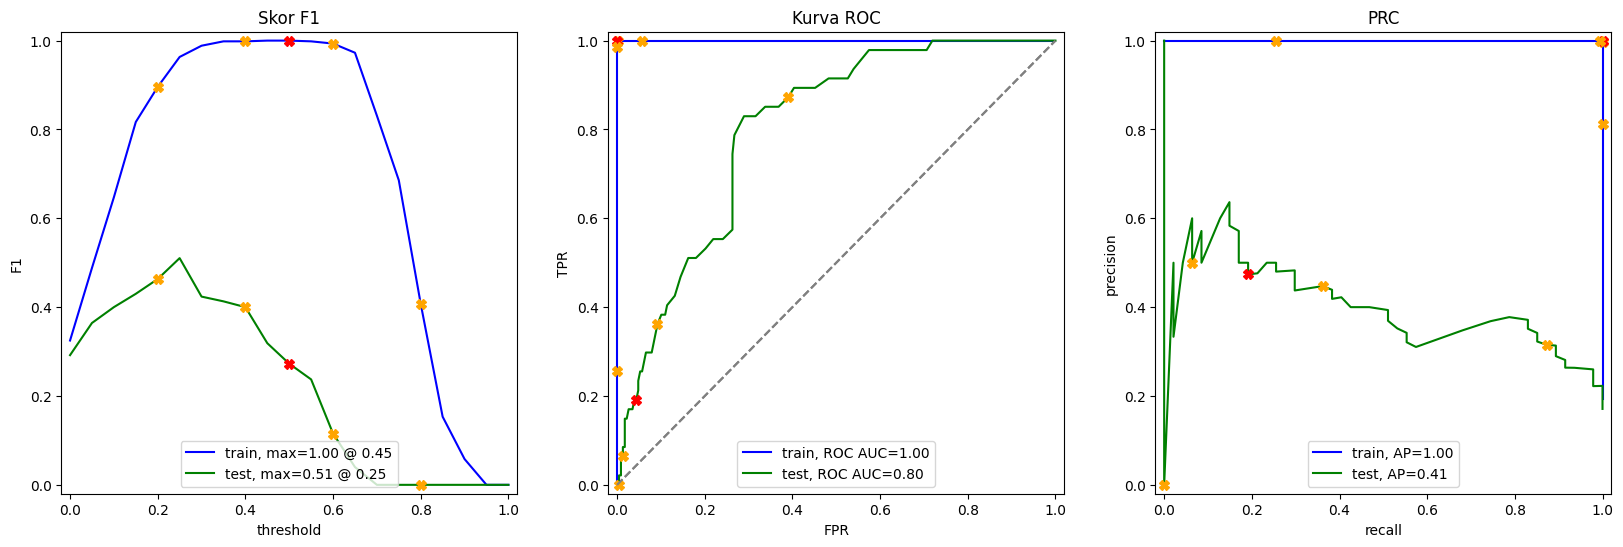

In [244]:
evaluate_model(RandomForestClassifier(),'None')

#### Linear Regression

           train    test
Accuracy  0.6517  0.8182
F1        0.3586  0.2647
APS       0.5220  0.4305
ROC AUC   0.6922  0.8007


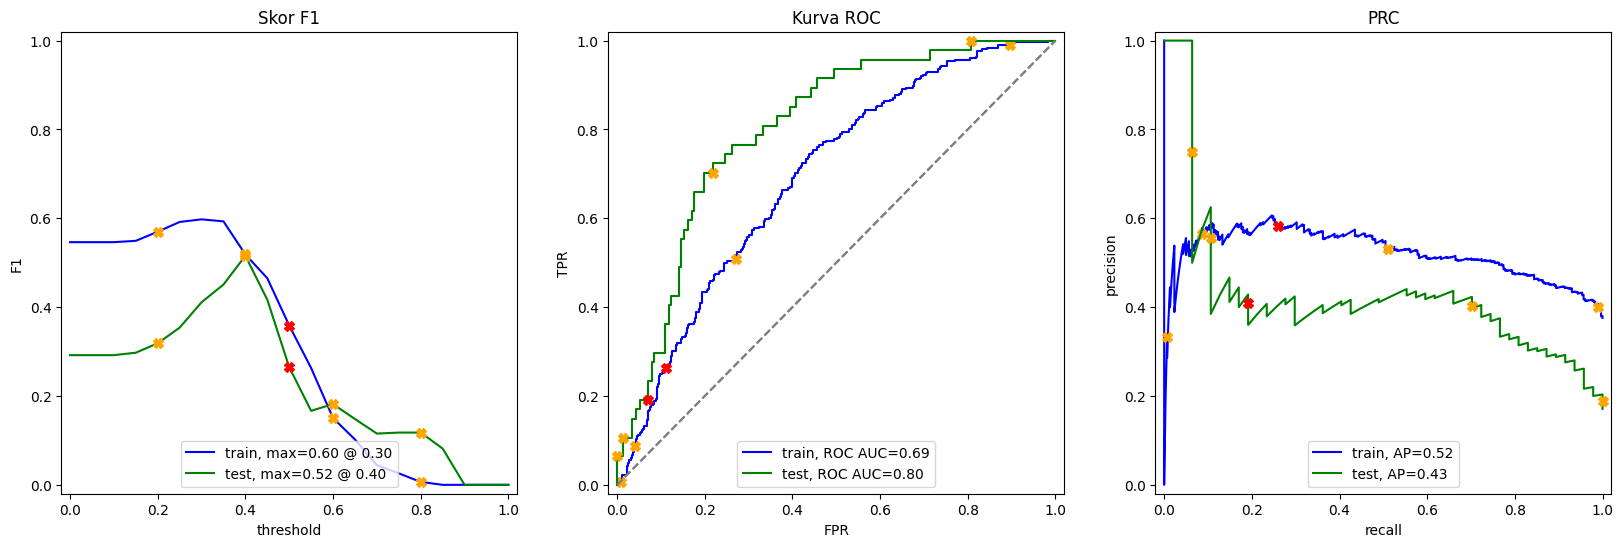

In [245]:
evaluate_model(LogisticRegression(random_state=12345),'downsample')

#### Decission Tree

           train    test
Accuracy  0.8505  0.8109
F1        0.3990  0.1613
APS       0.6047  0.2575
ROC AUC   0.8566  0.6598


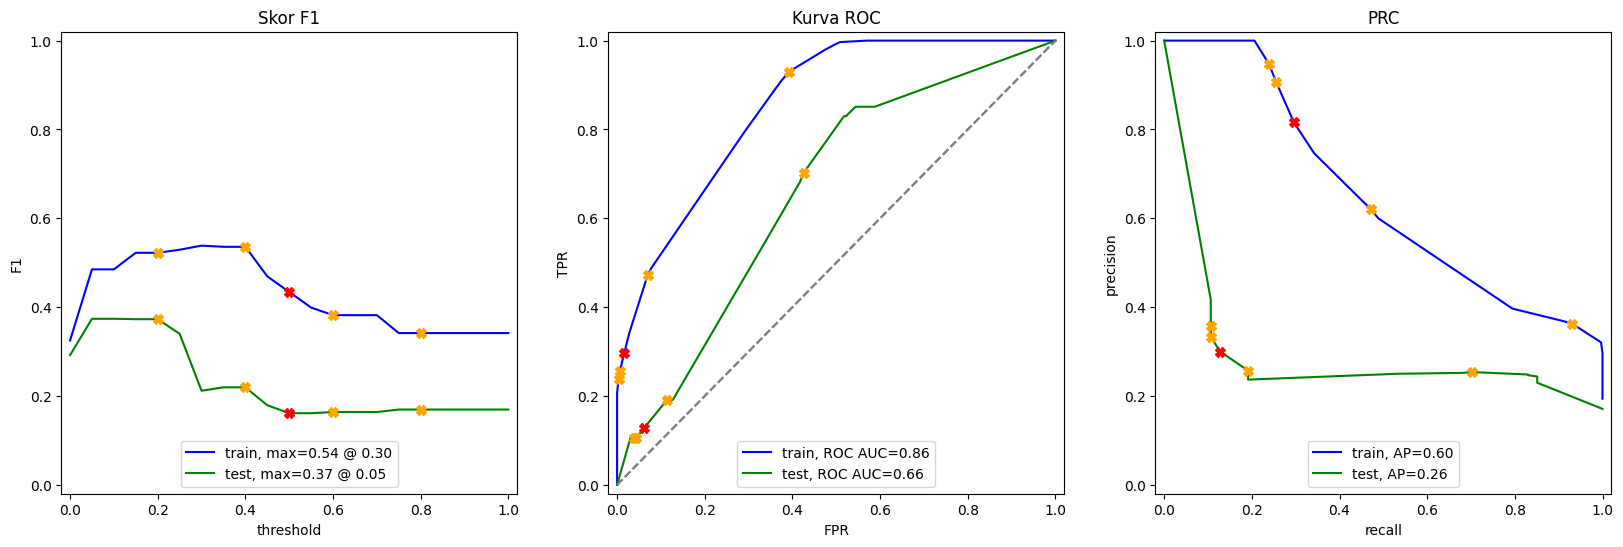

In [246]:
evaluate_model(DecisionTreeClassifier(random_state=12345,max_depth=8),'None')

#### GradientBoosting

           train    test
Accuracy  0.9530  0.8145
F1        0.8620  0.1905
APS       0.9873  0.3601
ROC AUC   0.9964  0.7563


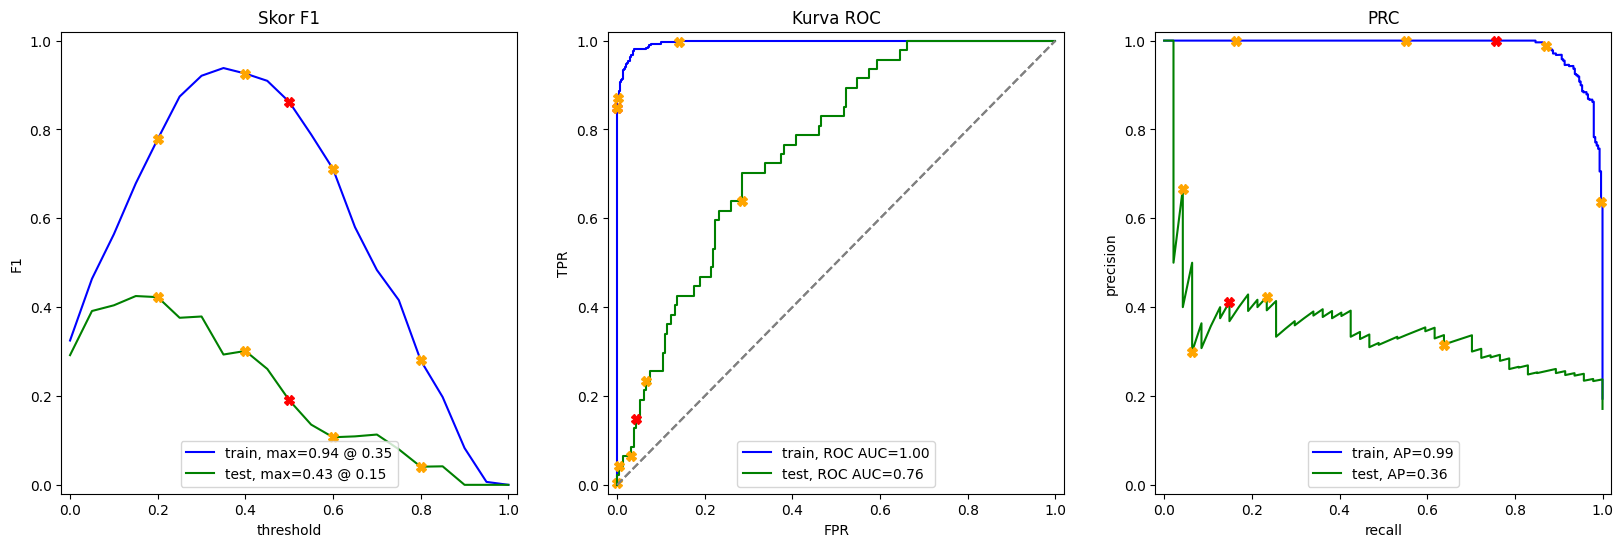

In [247]:
evaluate_model(GradientBoostingClassifier(random_state=12345,max_depth=5),'None')

#### SVC

           train    test
Accuracy  0.8061  0.8291
F1        0.0000  0.0000
APS       0.3625  0.3171
ROC AUC   0.6698  0.6485


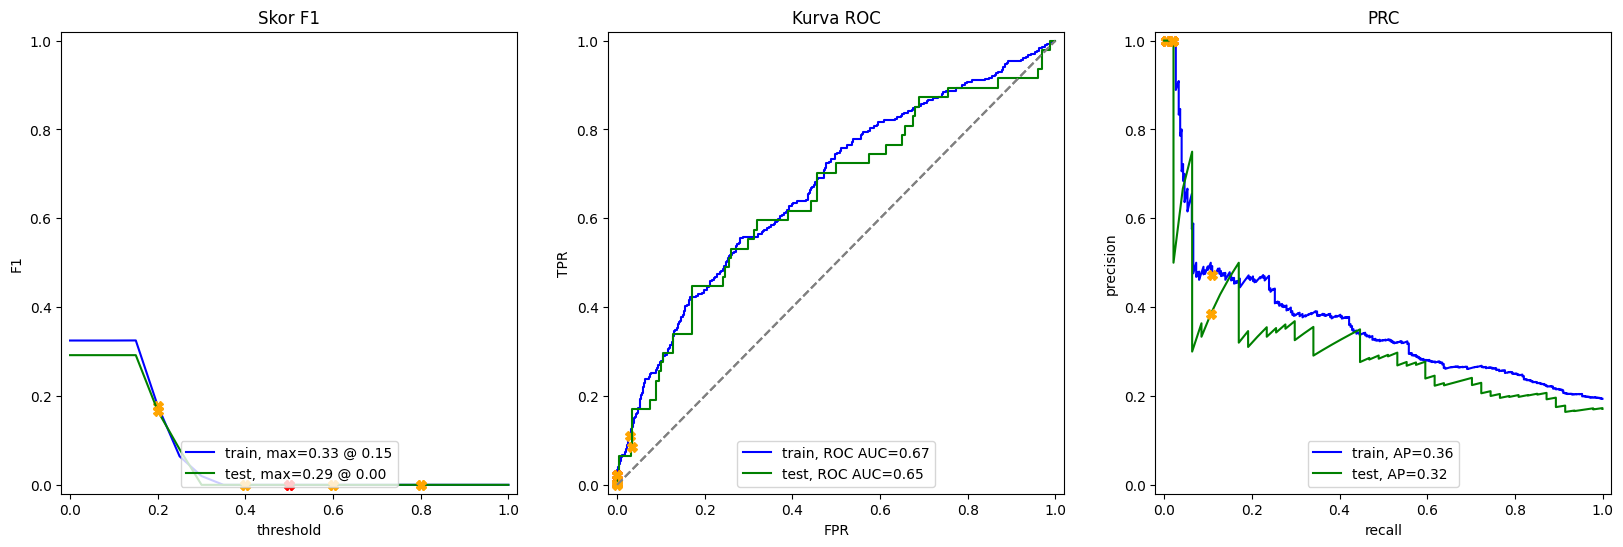

In [248]:
evaluate_model(SVC(probability=True,random_state=12345),'None')

#### KNN

           train    test
Accuracy  0.8241  0.7891
F1        0.4026  0.1944
APS       0.5233  0.2824
ROC AUC   0.8581  0.6784


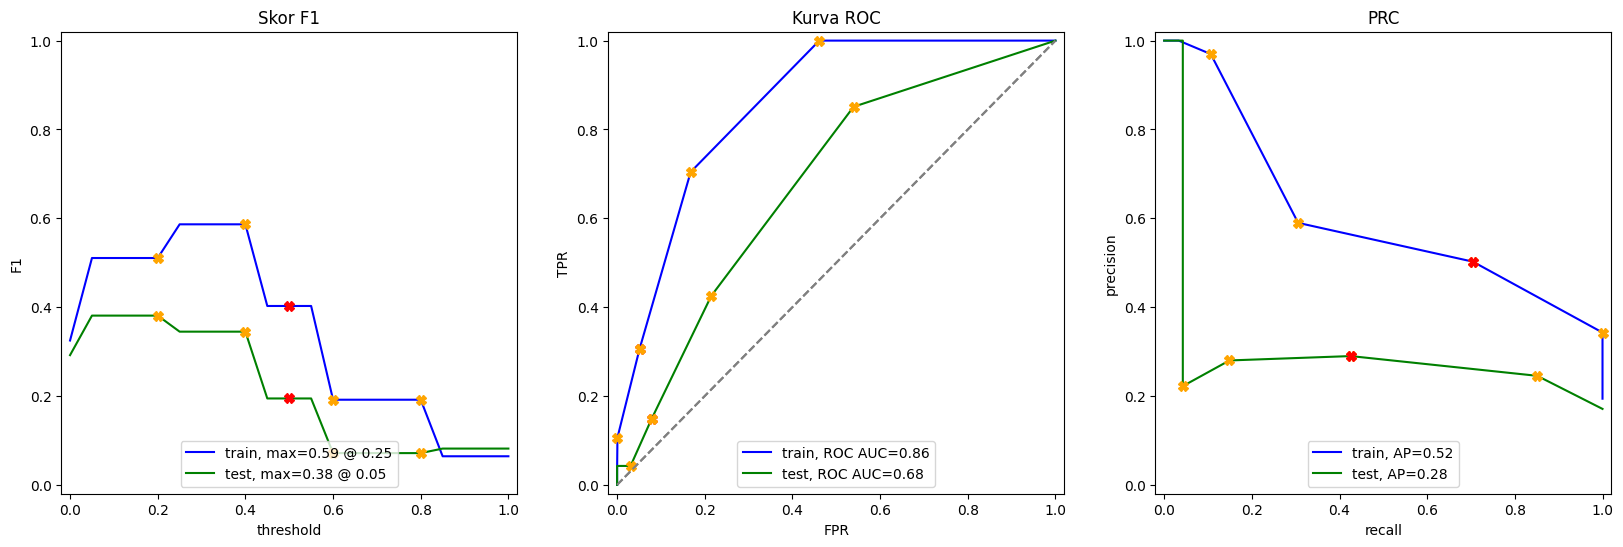

In [249]:
evaluate_model(KNeighborsClassifier(),'None')

### XGBoost

           train    test
Accuracy  0.8473  0.8255
F1        0.3612  0.1429
APS       0.7663  0.4218
ROC AUC   0.9239  0.7858


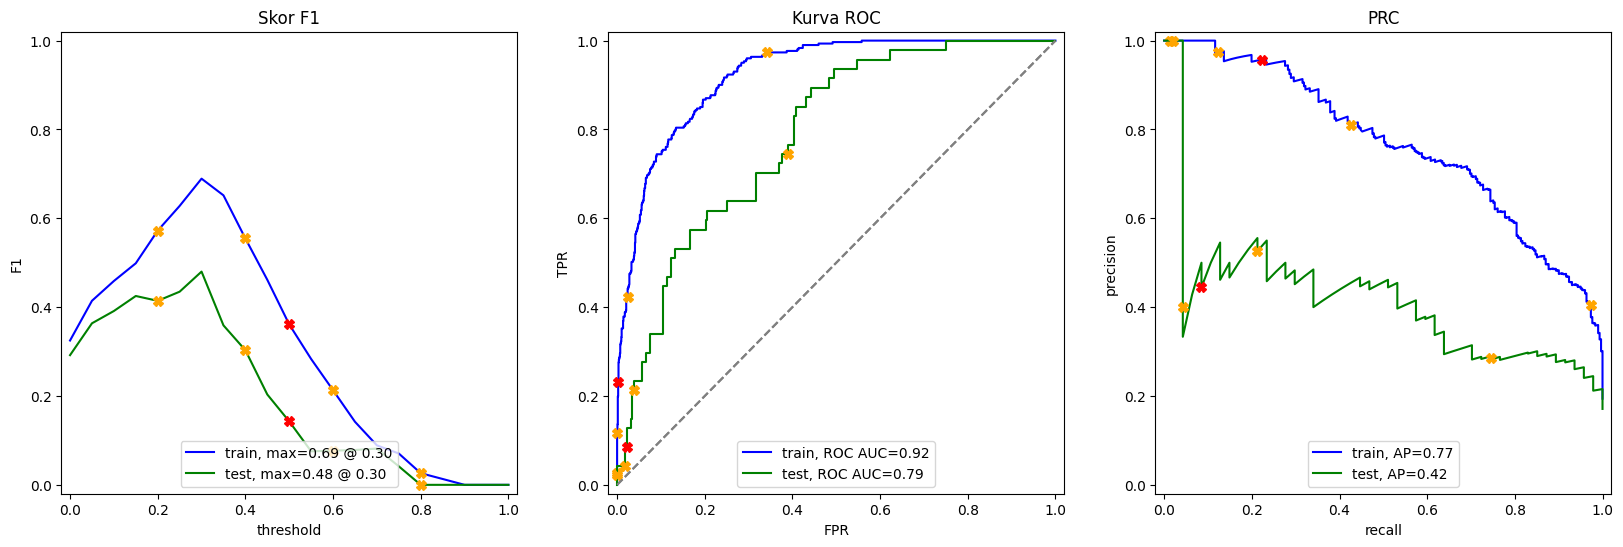

In [250]:
evaluate_model(xgb.XGBClassifier(max_depth=5,learning_rate=0.05),'None')

### LGBM

           train    test
Accuracy  0.8486  0.8291
F1        0.4391  0.2034
APS       0.6651  0.3852
ROC AUC   0.8744  0.7708


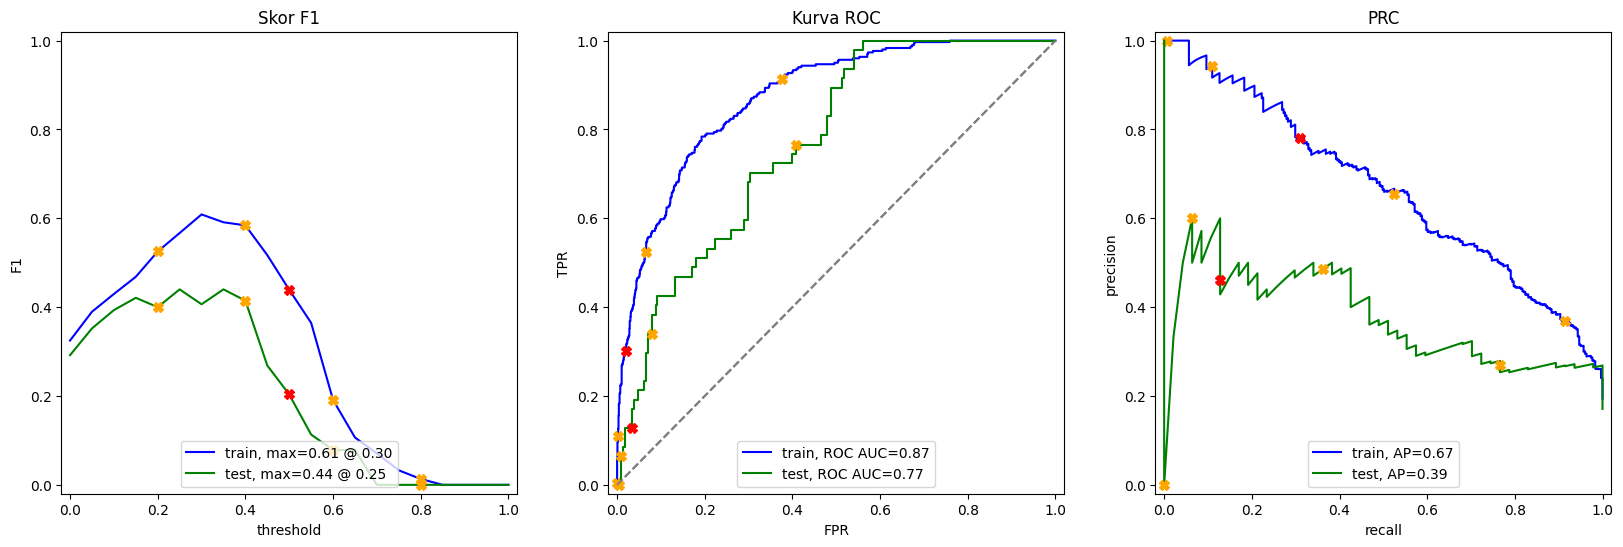

In [251]:
evaluate_model(lgb.LGBMClassifier(boosting_type='goss',learning_rate=0.04,num_leaves=10,random_state=12345),'None')

### Catboost

           train    test
Accuracy  0.8396  0.8364
F1        0.3102  0.1818
APS       0.6477  0.4642
ROC AUC   0.8566  0.8120


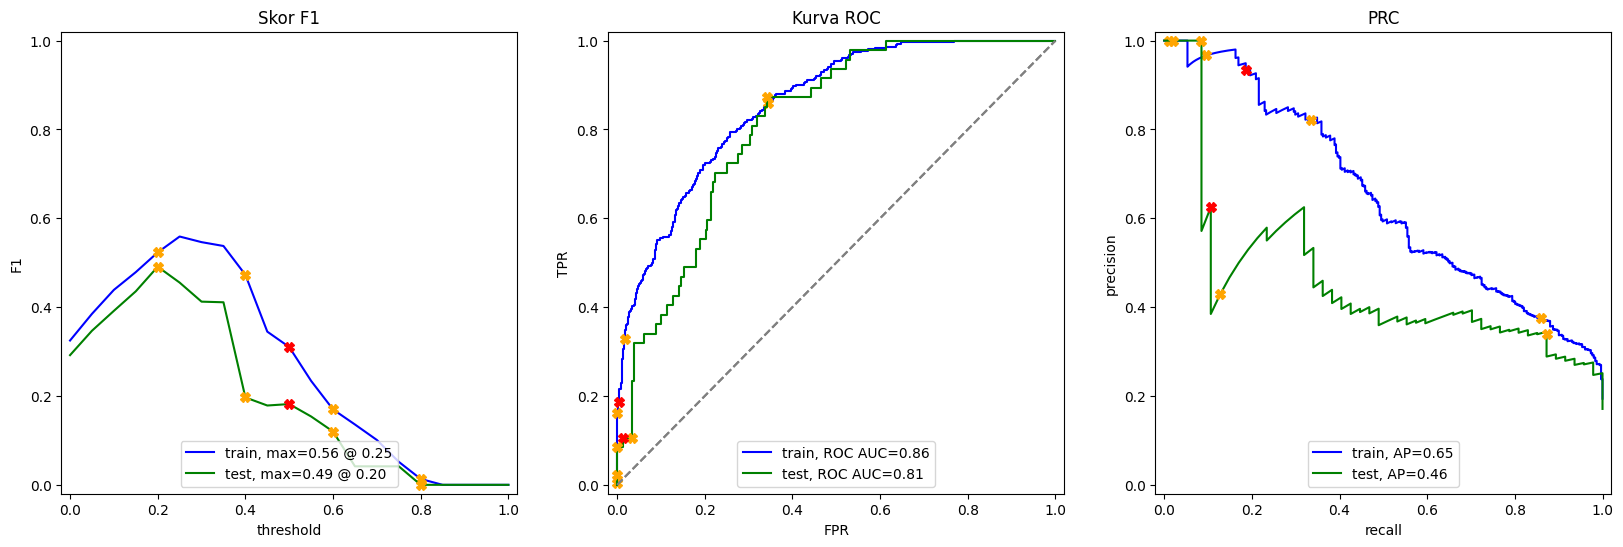

In [252]:
evaluate_model(CatBoostClassifier(random_state=12345,learning_rate=0.008,depth=4,verbose=0),'None')

### Neural Network

In [279]:
from tensorflow import keras
# Melakukan standarisasi fitur
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Membangun model Neural Network
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.005)
# Mengompilasi model
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

# Melatih model
model.fit(X_train_scale, y_train, epochs=8, verbose=0,validation_data=(X_test_scale, y_test))

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Akurasi Model: %.3f' % test_acc)

9/9 [==============================] - 0s 2ms/step - loss: 3.6877 - accuracy: 0.8291
Akurasi Model: 0.829


## Model memprediksi banyak nya banjir di masa yang akan datang
